In [1]:
import sys
import os
import numpy as np
import math

from collections import Counter
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric

from torch_geometric.datasets import QM9
from torch.utils.data import Dataset, DataLoader, random_split

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MolToSmiles

import matplotlib.pyplot as plt

from IPython.display import display

In [2]:
print(os.getcwd())

/home/jovyan/work


In [3]:
# Step 1: Load the QM9 dataset
dataset = QM9(root='./data/QM9')  # Download the dataset to './data/QM9'

# Print basic dataset information
print(f'Dataset length: {len(dataset)}')
print(f'Dataset features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset length: 130831
Dataset features: 11
Number of classes: 19


In [4]:
valid_molecules = []
valid_data = []

def process_molecule(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        Chem.SanitizeMol(mol) 
        mol = Chem.AddHs(mol)
        return mol
    except Exception as e:
        return None  # Return None to indicate failure

for idx, data in tqdm(enumerate(dataset), desc="Processing items", ncols=100):
    smiles = data.smiles  
    mol = process_molecule(smiles)
    
    if mol:
        valid_molecules.append(mol)
        valid_data.append(data)  # Keep the original data for valid molecules

Processing items: 0it [00:00, ?it/s][19:01:33] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 4 C, 5, is greater than permitted
Processing items: 682it [00:00, 5935.58it/s][19:01:33] Explicit valence for atom # 5 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 4 C, 5, is greater than permitted
Processing items: 1800it [00:00, 8840.39it/s][19:01:33] Explicit valence for atom # 6 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 3 C, 5, is greater than permitted
[19:01:33] Explicit valence for atom # 7 C, 5, is greater than permitted

In [5]:
remaining_date_cnt = len(dataset) - len(valid_molecules)
remaining_date_cnt

1403

In [6]:
def get_bond_length(mol, atom1, atom2):
    # Get coordinates for the atoms
    coords1 = mol.GetConformer().GetAtomPosition(atom1.GetIdx())
    coords2 = mol.GetConformer().GetAtomPosition(atom2.GetIdx())
    
    # Euclidean distance between the two atoms
    bond_length = coords1.Distance(coords2)
    return bond_length

def calculate_angle(mol, atom_a, atom_b, atom_c):
    # Get the 3D coordinates of atoms
    coords_a = mol.GetConformer().GetAtomPosition(atom_a.GetIdx())
    coords_b = mol.GetConformer().GetAtomPosition(atom_b.GetIdx())
    coords_c = mol.GetConformer().GetAtomPosition(atom_c.GetIdx())

    # Calculate the vectors
    vector_ab = np.array([coords_b.x - coords_a.x, coords_b.y - coords_a.y, coords_b.z - coords_a.z])
    vector_bc = np.array([coords_b.x - coords_c.x, coords_b.y - coords_c.y, coords_b.z - coords_c.z])

    # Compute the dot product and magnitudes
    dot_product = np.dot(vector_ab, vector_bc)
    mag_ab = np.linalg.norm(vector_ab)
    mag_bc = np.linalg.norm(vector_bc)

    # Check for zero-length vectors (to avoid division by zero)
    if mag_ab == 0 or mag_bc == 0:
        angle_rad = 0  
    else:
        cos_theta = dot_product / (mag_ab * mag_bc)
        # Clip the cosine value to be within [-1, 1] to handle numerical precision issues
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        angle_rad = np.arccos(cos_theta)

    return angle_rad

In [7]:
def get_bond_and_atom_info(dataitems):
    unique_bonds = set()  
    unique_atoms = set()  
    
    data_items   = list()
    bond_neighbors = dict()
    bond_lengths = list()
    bond_angles  = list()
    targets      = list() # Internal Energy

    bond_cnt_stats = {
        'bnd_cnt_per_mol' : list([0] * 31),
        'cnt_per_bnd'     : defaultdict(int),
        'molecules'       : list()
    }
    
    max_bond_count = 0
    max_neighbors  = 0 
    
    for data in tqdm(dataitems, ncols=100):
        smiles = data.smiles  # SMILES representation of the molecule
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        Chem.SanitizeMol(mol) 
        mol = Chem.AddHs(mol)
        
        # Generate 3D conformer with error handling
        try:
            if AllChem.EmbedMolecule(mol, randomSeed=42) == -1:
                raise ValueError(f"Embedding failed for molecule: {smiles}")
            if AllChem.UFFOptimizeMolecule(mol) == -1:
                raise ValueError(f"Optimization failed for molecule: {smiles}")
        except ValueError as e:
            continue  # Skip this molecule and proceed to the next
        
        data_items.append(data)

        bond_cnt_stats['molecules'].append(mol)
        bond_cnt_stats['bnd_cnt_per_mol'][len(mol.GetBonds())] += 1
        
        bond_neighbors[smiles] = {}

        targets.append(data.y[0][7]) # Internal Energy
        max_bond_count = max(max_bond_count, len(mol.GetBonds()))
        
        for bond in mol.GetBonds():
            atom1 = bond.GetBeginAtom()
            atom2 = bond.GetEndAtom()

            sorted_bond = tuple(sorted([atom1.GetSymbol(), atom2.GetSymbol()]))
            unique_bonds.add(sorted_bond)

            bond_cnt_stats['cnt_per_bnd'][sorted_bond] += 1     
            
            current_bond_length = get_bond_length(mol, atom1, atom2)
            bond_lengths.append(current_bond_length)
            # print(f"{sorted_bond=}")
            
            atom1_neighbors = atom1.GetBonds()
            atom2_neighbors = atom2.GetBonds()
            
            neighbors = atom1_neighbors + atom2_neighbors
            bond_neighbors[smiles][sorted_bond] = {
                'length': current_bond_length,
                'neighbors': list()
            }
            
            for neighbor in neighbors:
                if neighbor.GetIdx() != bond.GetIdx():  # Don't add the bond itself as a neighbor
                    a1 = neighbor.GetBeginAtom()
                    a2 = neighbor.GetEndAtom()
                    neighbor_length = get_bond_length(mol, a1, a2)
                    sorted_neighbor = tuple(sorted([a1.GetSymbol(), a2.GetSymbol()]))
                    
                    # Get the atoms of the neighboring bond
                    neighbor_atom = None
                    if neighbor.GetBeginAtomIdx() == atom1.GetIdx():
                        neighbor_atom = neighbor.GetEndAtom()
                    else:
                        neighbor_atom = neighbor.GetBeginAtom()
        
                    # Calculate the angle between the bond and the neighboring bond
                    angle = calculate_angle(mol, atom1, atom2, neighbor_atom)
                    
                    bond_lengths.append(neighbor_length)
                    bond_angles.append(angle)
                    bond_neighbors[smiles][sorted_bond]['neighbors'].append((sorted_neighbor, neighbor_length, angle))
                else:
                    # print(f"Check!")
                    pass
            max_neighbors = max(max_neighbors, len(bond_neighbors[smiles][sorted_bond]['neighbors']))
        
        for atom in mol.GetAtoms():
            unique_atoms.add((atom.GetAtomicNum(), atom.GetSymbol()))  # Add the atomic number to identify unique atoms

    b_lengths_mean = np.mean(bond_lengths)
    b_lengths_std  = np.std(bond_lengths)
    
    b_angles_mean = np.mean(bond_angles)
    b_angles_std  = np.std(bond_angles)

    targets_means = np.mean(targets)
    targets_std   = np.std(targets)
        
    return (
        data_items, unique_bonds, unique_atoms, bond_neighbors, 
        max_neighbors, max_bond_count, b_lengths_mean, b_lengths_std,
        b_angles_mean, b_angles_std, targets_means, targets_std, bond_cnt_stats
    )

In [8]:
(
    data_items, unique_bonds, unique_atoms, bond_neighbors, 
    max_neighbors, max_bond_count, b_lengths_mean, b_lengths_std,
    b_angles_mean, b_angles_std, targets_means, targets_std, bond_cnt_stats
) = get_bond_and_atom_info(valid_data)

100%|███████████████████████████████████████████████████████| 129428/129428 [29:32<00:00, 73.01it/s]


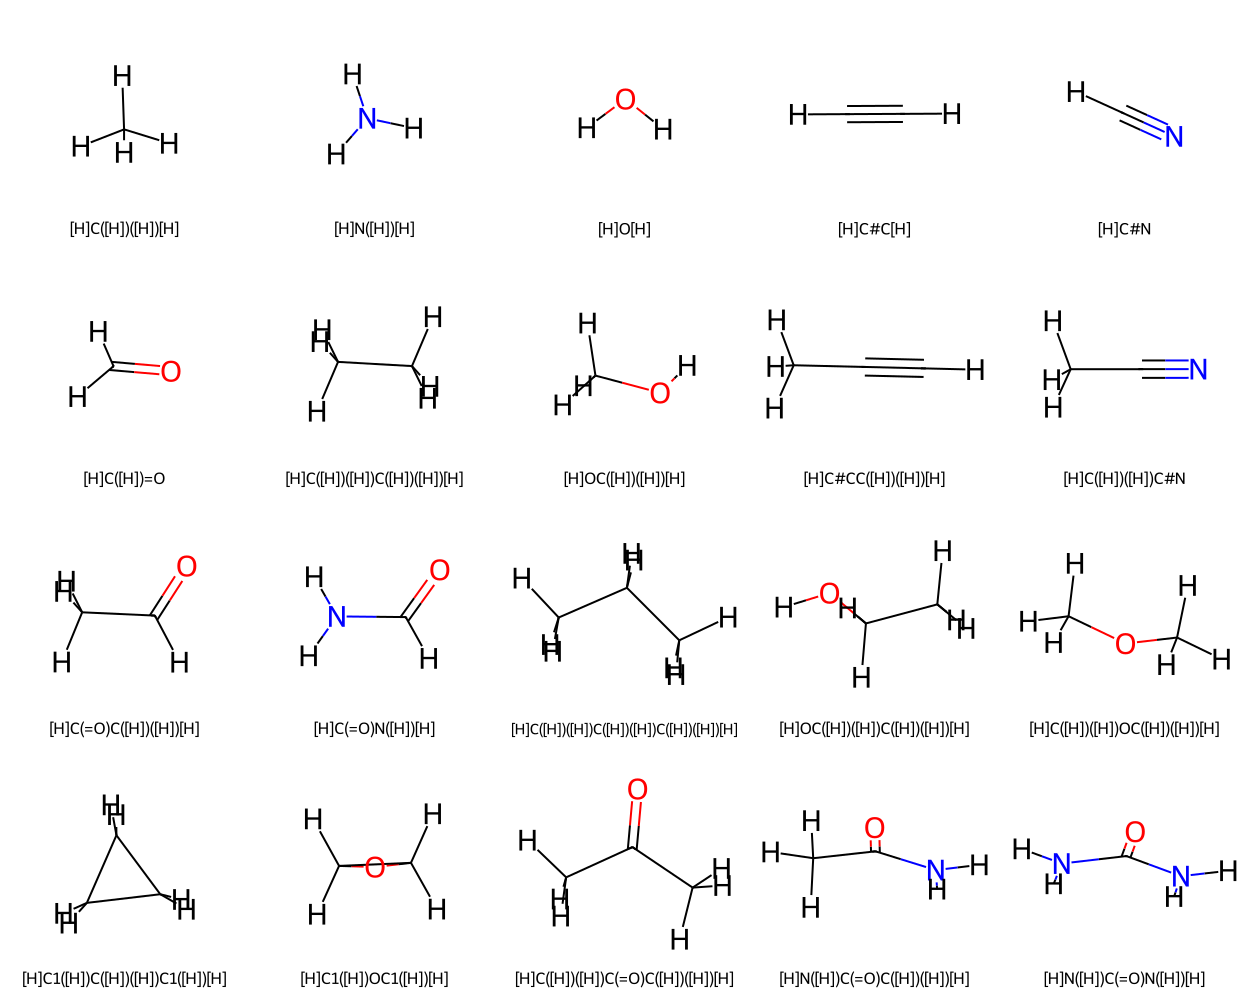

In [9]:
desired_count = 5 * 4  # 5 molecules per row, 4 rows
molecules = bond_cnt_stats['molecules'][:desired_count] 

if len(molecules) < desired_count:
    molecules.extend([None] * (desired_count - len(molecules)))  # Pad with None if too few

# Get SMILES strings for legends
smiles_legends = [MolToSmiles(mol) if mol else "" for mol in molecules]

# Draw the grid
grid_image = Draw.MolsToGridImage(
    mols=molecules,
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=smiles_legends  # Skip legend for padded slots
)

# Display the image
display(grid_image)

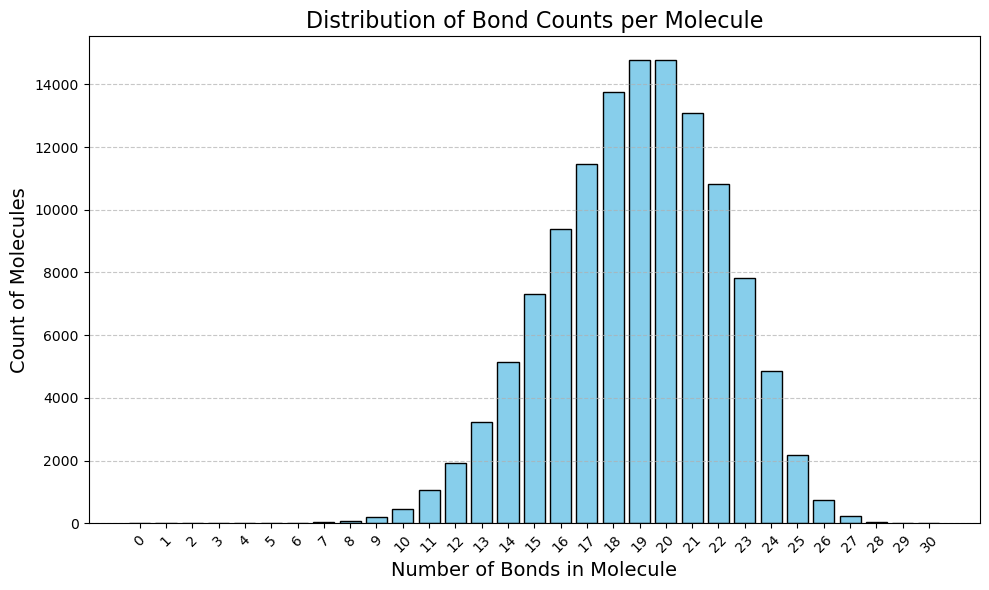

In [10]:
# Data
bnd_cnt_per_mol = bond_cnt_stats['bnd_cnt_per_mol']

# Create a bar chart
x = list(range(len(bnd_cnt_per_mol)))  # Number of bonds
plt.figure(figsize=(10, 6))
plt.bar(x, bnd_cnt_per_mol, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Number of Bonds in Molecule', fontsize=14)
plt.ylabel('Count of Molecules', fontsize=14)
plt.title('Distribution of Bond Counts per Molecule', fontsize=16)
plt.xticks(x, fontsize=10, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

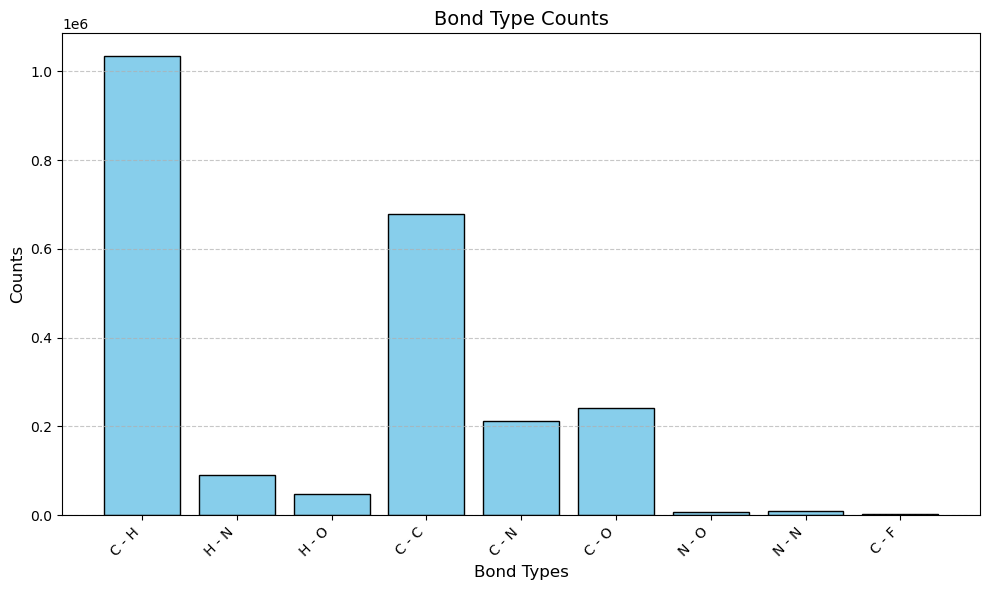

In [11]:
bond_counts = bond_cnt_stats['cnt_per_bnd']

bond_types = [' - '.join(bond) for bond in bond_counts.keys()]
counts = list(bond_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(bond_types, counts, color='skyblue', edgecolor='black')

plt.xlabel('Bond Types', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Bond Type Counts', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [50]:
class BiMDataset(Dataset):
    def __init__(
        self, data_items, unique_bonds, unique_atoms, bond_neighbors, 
        max_neighbors, max_bond_count, b_lengths_mean, b_lengths_std, 
        b_angles_mean, b_angles_std, targets_means, targets_std
    ):
        self.data_list      = data_items
        self.unique_bonds   = unique_bonds
        self.unique_atoms   = unique_atoms
        self.bond_neighbors = bond_neighbors
        
        self.max_neighbors  = max_neighbors       
        self.max_bond_count = max_bond_count
        
        self.b_lengths_mean = b_lengths_mean
        self.b_lengths_std  = b_lengths_std
        
        self.b_angles_mean = b_angles_mean
        self.b_angles_std  = b_angles_std
        
        self.targets_means = targets_means
        self.targets_std   = targets_std
        
        self.bond_to_id = {bond: (idx+1) for idx, bond in enumerate(self.unique_bonds)}
        self.id_to_bond = {(idx + 1): bond for idx, bond in enumerate(self.unique_bonds)}
        
    def __len__(self):
        return len(self.data_list)

    def __normalized_bond_length__(self, b_length):
        return (b_length - self.b_lengths_mean) / self.b_lengths_std

    def __normalized_bond_angle__(self, b_angle):
        return (b_angle - self.b_angles_mean) / self.b_angles_std 

    def __normalized_bond_energy__(self, b_energy):
        return (b_energy - self.targets_means) / self.targets_std 
            
    def __prepare_data__(self, item):
        smiles = item.smiles  # SMILES representation of the molecule
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        Chem.SanitizeMol(mol) 
        mol = Chem.AddHs(mol)

        bond_types = []
        bond_lengths = []
        neighbor_infos = []

        target = self.__normalized_bond_energy__(item.y[0][7]) # Internal Energy
        
        for bond in mol.GetBonds():
            atom1 = bond.GetBeginAtom()
            atom2 = bond.GetEndAtom()
            sorted_bond = tuple(sorted([atom1.GetSymbol(), atom2.GetSymbol()]))
            
            curr_bond_length = self.bond_neighbors[smiles][sorted_bond]['length']
            n_infos          = self.bond_neighbors[smiles][sorted_bond]['neighbors']
            
            bond_types.append(self.bond_to_id[sorted_bond])
            bond_lengths.append(
                self.__normalized_bond_length__(curr_bond_length)
            )

            current_bonds_neighbor_infos = [
                (
                    self.bond_to_id[n_bond], 
                    self.__normalized_bond_length__(n_bond_length), 
                    self.__normalized_bond_angle__(n_bond_angle)
                ) for n_bond, n_bond_length, n_bond_angle in n_infos
            ]
            
            # print(f"{self.max_neighbors=}")
            padded_bonds = self.max_neighbors - len(n_infos)
            # print(f"padding required={padded_bonds}")
            current_bonds_neighbor_infos += [(0, 0, 0) for _ in range(padded_bonds)]
            neighbor_infos.append(current_bonds_neighbor_infos)
           
        bond_types_tensor = torch.tensor(bond_types, dtype=torch.float32)
        bond_lengths_tensor = torch.tensor(bond_lengths, dtype=torch.float32)
        neighbor_infos_tensor = torch.tensor(neighbor_infos, dtype=torch.float32) 
        
        pad_size = self.max_bond_count - neighbor_infos_tensor.size(0)
        
        padding_tensor = torch.zeros(pad_size, neighbor_infos_tensor.size(1), neighbor_infos_tensor.size(2))
        padded_neighbor_infos_tensor = torch.cat([neighbor_infos_tensor, padding_tensor], dim=0) 

        padding_tensor = torch.zeros(pad_size)
        padded_bond_types_tensor = torch.cat([bond_types_tensor, padding_tensor.clone().detach()], dim=0)
        padded_bond_lengths_tensor = torch.cat([bond_lengths_tensor, padding_tensor.clone().detach()], dim=0)
        
        # print(f"{padded_neighbor_infos_tensor.shape=}")
        return padded_bond_types_tensor, padded_bond_lengths_tensor, padded_neighbor_infos_tensor, target
        
    def __getitem__(self, idx):
        curr_item = self.data_list[idx]
        return self.__prepare_data__(curr_item)

In [51]:
bim_dataset = BiMDataset(
    data_items, unique_bonds, unique_atoms, bond_neighbors, 
    max_neighbors, max_bond_count, b_lengths_mean, b_lengths_std, 
    b_angles_mean, b_angles_std, targets_means, targets_std
)

In [42]:
bim_dataloader = DataLoader(bim_dataset, batch_size=4, shuffle=False)

In [52]:
# Save the dataset to a local file
dataset_file = './data/QM-9-BiM-Dataset.pt'
torch.save(bim_dataset, dataset_file)
print(f"Dataset saved to {dataset_file}")

Dataset saved to ./data/QM-9-BiM-Dataset.pt


In [ ]:
# Path to the saved dataset
dataset_file = './data/QM-9-BiM-Dataset.pt'
# Load the saved dataset
bim_dataset_2 = torch.load(dataset_file)

print(f"Dataset loaded from {dataset_file}")

In [ ]:
print(dir(bim_dataset_2))